In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
import random

In [2]:
print(os.getcwd())

#creo lista di nomi 
directories = ['data/train/', 
               'data/val/', 
               'data/test/']

train_file_names = [f for f in listdir(directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names] 

/Users/orobix/Documents/Thesis/Source/Code


In [3]:
#numero immagini per categoria
scans = ['CT','MRI','PET']
numbers=[]
minimi=[]

for directory in directories:    
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2]==scan[:2]])
        #print('Numbero di immagini', scan, 'in', directory,':', a)
        numbers.append(a)
    minimi.append(min(numbers))

#print(minimi)
#=> è sempre la PET che ha il numero minore

In [4]:
#creo la lista di file bilanciata
train_final_file_names=[]
val_final_file_names=[]
test_final_file_names=[]
_final_file_names = [train_final_file_names, val_final_file_names, test_final_file_names] 

l=[]
for directory,minimo,name in zip(directories, minimi,_final_file_names):    
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2]==scan[:2]]
        random.shuffle(l)
        l = l[:minimo]
        name.extend(l) #estendo la lista (don't append)
        
# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
# 
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

In [5]:
#Data augmentation: to do

In [6]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(val_final_file_names) ,", Test:", len(test_final_file_names))

DATASET
Training 594 , Validation: 171 , Test: 87


## Converto le immagini in tensori

In [7]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

### X

In [8]:
def WriteAndArrayImages(path):
    x = io.imread(path[random.randint(0,100)])
    x = cv2.resize(x, dsize=(128,128))
    
    for img in path[1:]:
        img = io.imread(img)
        img = cv2.resize(img, dsize=(128,128))
        x = np.dstack((x,img))
    x = np.rollaxis(x,-1)
    return x

(594, 128, 128)
(171, 128, 128)
(87, 128, 128)


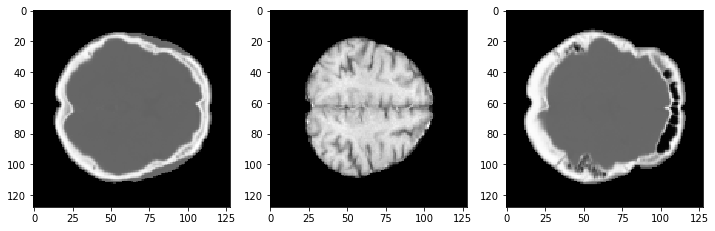

In [9]:
import numpy as np

#paths per leggere le immagini
train_paths=[]
val_paths=[]
test_paths=[]
_paths=[train_paths,val_paths,test_paths]

for path,name,directory in zip(_paths,_final_file_names,directories):
    for f in name:
        path.append(directory+f)

#leggo le immagini e le stacco una sopra l'altra
x_train = WriteAndArrayImages(train_paths)
x_val = WriteAndArrayImages(val_paths)
x_test = WriteAndArrayImages(test_paths)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#plot images from each dataset
f, axarr = plt.subplots(1,3,figsize=(12, 12))
axarr[0].imshow(x_train[0], cmap=plt.cm.gray)
axarr[1].imshow(x_val[0], cmap=plt.cm.gray)
axarr[2].imshow(x_test[0], cmap=plt.cm.gray)

### Y

In [10]:
def MakeLabels(_name_files):
    y=[]
    for text in _name_files:
        fileNameOnly = text[:text.find(ext)]
        y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
    for i, item in enumerate(y):
        if item == 'CT':
            y[i] = 0
        elif item == 'MRI':
            y[i] = 1
        else: y[i] = 2    
    return y

In [11]:
#estensione immagini
ext = '.png'

#costruisco le lables
y_train = MakeLabels(_final_file_names[0])
y_val = MakeLabels(_final_file_names[1])
y_test = MakeLabels(_final_file_names[2])

In [20]:
#check
X = [x_train, x_val, x_test]
Y = [y_train, y_val, y_test]

for x,y in zip(X,Y):
    if len(x) != len(y):
        print(len(x))
        print(len(y))
        print('Error! La lunghezza delle liste non combacia!')
    else: 
        print('Ok, le lunghezze combaciano con le X')

#controlla numero di cluster (expected 3)
n_clusters = len(np.unique(y))
print('Clusters:', n_clusters)

Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Clusters: 3


### Tensori

In [13]:
def ReshapeAndNormalize(array):
    array=array.reshape(array.shape + (1,))
    array=array/255.
    return array

#n.b. run only once

In [14]:
#preparo i tensori per passarli all'autoencoder
x_train = ReshapeAndNormalize(x_train)
x_val = ReshapeAndNormalize(x_val)
x_test = ReshapeAndNormalize(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(594, 128, 128, 1)
(171, 128, 128, 1)
(87, 128, 128, 1)


## AutoEncoder Model 

In [23]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model

Using TensorFlow backend.
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/orob

### Hyperparameters (to edit)

In [48]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

dims = [x.shape[-1], 500, 500, 1000, 200] #TO EDIT

init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 50 #####
batch_size = 16 #####
save_dir = './results'

In [49]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [50]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1000      
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 1000)              501000    
_________________________________________________________________
encoder_3 (Dense)            (None, 200)               200200    
_________________________________________________________________
decoder_3 (Dense)            (None, 1000)              201000    
_________________________________________________________________
decoder_2 (Dense)            (None, 500)               500500   

### Clustering Layer

In [51]:
from keras.engine.topology import Layer

In [52]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Pretrain

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(x, 
                x, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_validation, x_validation),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

tensorboard --logdir=/tmp/autoencoder

In [45]:
#plot loss

In [53]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

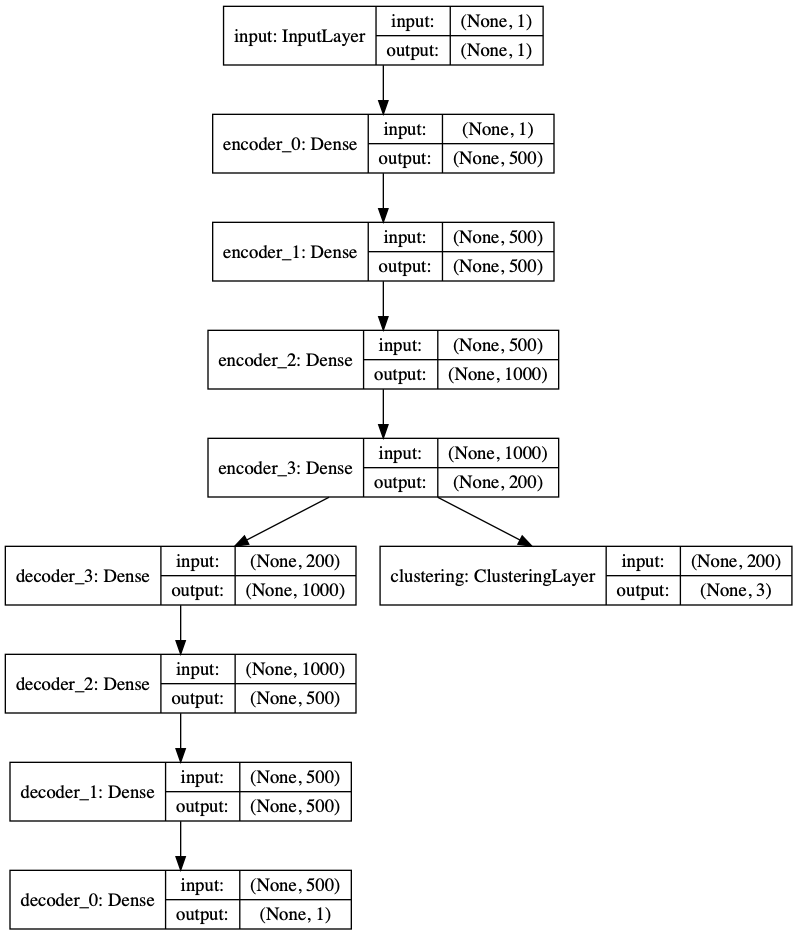

In [54]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

## Inizialize cluster centers using k-means

In [56]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

ValueError: Error when checking input: expected input to have 2 dimensions, but got array with shape (87, 128, 128, 1)

In [57]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

## Training

### Deep clustering

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

### Start training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')